# MOT data analysis
This notebook will use an sqlite database file already generated by another notebook.  It will perform some SQL querying to filter and sort the data.  Then make use of pandas, numpy, matplotlib, seaborn etc to do some exploratory data analysis.  My intention is to then train some machine learning models to try to provide useful insight from the data such as trends, predicted test pass rates etc.

Dataset sourced from [http://data.dft.gov.uk/anonymised-mot-test/test_data/dft_test_result_2019.zip](https://data.gov.uk/dataset/e3939ef8-30c7-4ca8-9c7c-ad9475cc9b2f/anonymised-mot-tests-and-results)

Dataset stored locally in an SQlite database.

## Load in dataset

In [37]:
import pandas as pd
import os
# For sqlite database
import sqlite3
from sqlite3 import Error

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Import and create a new database file
def create_connection(path):
    connection = None
    try:
        connection = sqlite3.connect(path)
        print("Connection to SQLite DB successful")
    except Error as e:
        print(f"The error '{e}' occurred")

    return connection

connection = create_connection(os.path.join('data','mot.sqlite'))

Connection to SQLite DB successful


In [3]:
# Create function to execute simple query
def execute_query(connection, query, firstonly=False, verbose=True):
    cursor = connection.cursor()
    try:
        cursor.execute(query)
        connection.commit()
        if verbose:print("Query executed successfully");
    except Error as e:
        print(f"The error '{e}' occurred")
    if firstonly:
        return cursor.fetchone()
    else:
        return cursor.fetchall()

# Run some initial queries
There are 39 million entries in the  in the database! My computer won't be able to process all of that practically.  So we'll need to come up with a way to produce a meaningfully representative subset of it with less records.  Random subsampling etc is probably OK in this case, due to the scale

In [ ]:
# Get number of rows in database
response = execute_query(connection,'''SELECT COUNT(test_id) FROM mot1;''')
print(f'Total number of entries in mot1 table is: {response[0][0]}')

In [ ]:
pd.read_sql_query('''SELECT * 
FROM mot1 
WHERE vehicle_id IN (
    SELECT vehicle_id 
    FROM mot1 
    ORDER BY RANDOM() 
    LIMIT 10)''', connection)

In [ ]:
pd.read_sql_query('''SELECT * 
FROM mot1 
WHERE postcode_area LIKE "G"
LIMIT 5''', connection)

In [ ]:
response = execute_query(connection,'''SELECT COUNT(vehicle_id) FROM mot1
WHERE postcode_area LIKE "G";''')
print(f'Total number of test records in G postcode is: {response[0][0]}')

response = execute_query(connection,'''SELECT COUNT(DISTINCT vehicle_id) FROM mot1
WHERE postcode_area LIKE "G";''')
print(f'Total number of unique vehicles in G postcode is: {response[0][0]}')

**Observation**
There were 630k tests in G postcode, but only 490k unique vehicles

In [ ]:
# Get number of rows in database
response = execute_query(connection,'''SELECT COUNT(DISTINCT vehicle_id) FROM mot1
WHERE postcode_area LIKE "G"
AND fuel_type LIKE "DI";''')
print(f'Total number of Diesel cars in G postcode is: {response[0][0]}')

In [ ]:
# Get number of rows in database
response = execute_query(connection,'''SELECT COUNT(DISTINCT vehicle_id) FROM mot1
WHERE postcode_area LIKE "G"
AND fuel_type LIKE "DI"
AND test_result = 1;''')
print(f'Total number of Diesel cars in G postcode is: {response[0][0]}')
#??? not sure about this

## Extract dataframe from SQL database
Make sense of data and create the df dataframe

In [120]:
df = pd.read_sql_query('''
SELECT 
    mot1.test_id, mot1.vehicle_id, mot1.test_date,
    mot1.test_class_id, mot1.test_type, 
    passtable.test_result_code, mot1.test_mileage,
    mot1.postcode_area, mot1.make, mot1.model, mot1.colour,
    mot1.fuel_type, mot1.cylinder_capacity, mot1.first_use_date
FROM mot1
LEFT JOIN passtable 
ON passtable.test_result = mot1.test_result
WHERE postcode_area LIKE "G";
''', connection, parse_dates=['first_use_date','test_date'])

In [121]:
# Drop some columns
df = df.drop('postcode_area',axis=1)

# Add some columns
df['vehicle_age'] = (df['test_date'] - df['first_use_date']).dt.days

In [122]:
df.head()

,test_id,vehicle_id,test_date,test_class_id,test_type,test_result_code,test_mileage,make,model,colour,fuel_type,cylinder_capacity,first_use_date,vehicle_age
0,89719943,343699759,2019-04-01,4,NT,P,43500,PEUGEOT,BOXER,WHITE,DI,2198,2014-03-20,1838
1,273750413,753234121,2019-04-01,4,NT,P,29730,BMW,X1,BLACK,DI,1995,2016-03-18,1109
2,839477323,1499010618,2019-04-01,4,NT,F,143129,VOLKSWAGEN,CADDY,WHITE,DI,1968,2006-09-26,4570
3,1614166795,537938057,2019-04-01,4,RT,P,27114,AUDI,A5,WHITE,DI,1968,2015-09-02,1307
4,707053023,191299390,2019-04-01,4,NT,F,197200,BMW,3 SERIES,BLACK,DI,1995,2006-06-19,4669


In [123]:
# Change to categorical datatypes
df['make'] = df['make'].astype('category')
df['model'] = df['model'].astype('category')
df['colour'] = df['colour'].astype('category')
df['fuel_type'] = df['fuel_type'].astype('category')
df['test_type'] = df['test_type'].astype('category')
df['test_result_code'] = df['test_result_code'].astype('category')
df['test_class_id'] = df['test_class_id'].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 631635 entries, 0 to 631634
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   test_id            631635 non-null  int64         
 1   vehicle_id         631635 non-null  int64         
 2   test_date          631635 non-null  datetime64[ns]
 3   test_class_id      631635 non-null  category      
 4   test_type          631635 non-null  category      
 5   test_result_code   631635 non-null  category      
 6   test_mileage       631635 non-null  int64         
 7   make               631635 non-null  category      
 8   model              631635 non-null  category      
 9   colour             631635 non-null  category      
 10  fuel_type          631635 non-null  category      
 11  cylinder_capacity  631635 non-null  int64         
 12  first_use_date     631635 non-null  datetime64[ns]
 13  vehicle_age        631635 non-null  int64   

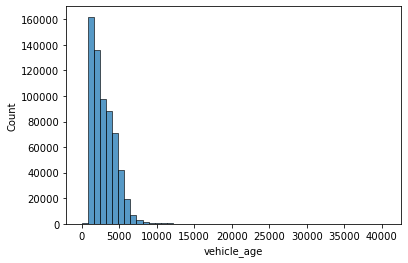

In [124]:
sns.histplot(df['vehicle_age'].astype('int'), bins=50);

In [ ]:
sns.pairplot(df[['vehicle_age','test_mileage','cylinder_capacity','test_result_code']], 
             hue='test_result_code',
             diag_kind='hist');

We have 3 numerical parameters to play with. age, mileage, cylinder capacity.  This is only for a subset of 10000 records (out of 600k in glasgow postcode).

# Attempt to transform the data to one entry per vehicle_id

Check if dataset is ordered by test date, so in our df.groupby().apply, we can simply grab the first element in the group to get the first test of that vehicle.

In [ ]:
# Test if data always increasing
df['test_date'].is_monotonic

In [ ]:
# Try groupby method to get new dataframe of 1 row per vehicle
def vehicleGrouping(df):
    df = df.drop('vehicle_id', axis=1)
    return(df.iloc[0])

dfv = df.groupby('vehicle_id').apply(vehicleGrouping)
dfv.head()

In [ ]:
# Fix categorical data types
dfv['make'] = dfv['make'].astype('category')
dfv['model'] = dfv['model'].astype('category')
dfv['colour'] = dfv['colour'].astype('category')
dfv['fuel_type'] = dfv['fuel_type'].astype('category')
dfv['test_type'] = dfv['test_type'].astype('category')
dfv['test_result_code'] = dfv['test_result_code'].astype('category')
dfv['test_class_id'] = dfv['test_class_id'].astype('category')
dfv.info()

In [ ]:
# Check if index is unique, means one row per vehicle
dfv.index.is_unique

In [ ]:
# Repeat the previous pairplot matrix, now we have made it one row per vehicle.  
# Should make less common to have the PRS, ABR, ABA test_results
sns.pairplot(dfv[['vehicle_age','test_mileage','cylinder_capacity','test_result_code']], 
             hue='test_result_code',
             diag_kind='hist');

In [ ]:
dfv.describe()

In [ ]:
dfv.describe(include='category')
# dfv.info()

In [ ]:
import matplotlib.pyplot as plt
ax1 = plt.axes();
ax1.plot(df['test_mileage'],df['test_result'],'.',markersize=1, alpha=0.1);

In [ ]:
df_pass = df.copy()

print('Num rows:',len(df_pass))

df_pass = df_pass.drop(df[df['test_result'] > 2].index,axis=0)
print('Num rows:',len(df_pass),' (after dropping the rows with test aborts)')

In [ ]:
ax1 = plt.axes();
ax1.plot(df_pass['test_mileage'],df_pass['test_result'],'.',markersize=1, alpha=0.1);

# Other stuff

In [ ]:
# Print first 5 entries
pd.read_sql_query('''SELECT * FROM mot1 LIMIT 5''', connection)

# EDA on vehicle make
There are 10,542 distinct vehicle makes in the total database.  

In [ ]:
count_makes = execute_query(connection,'''SELECT COUNT( DISTINCT make ) FROM mot1;''')
print(f'Number of distinct vehicle makes: {count_makes[0][0]}')

Counting the number of mot tests recorded for each car make.  Ford is the largest... but because this is the number of tests recorded, it could mean that Fords are really unreliable, or just really badly maintained and keep failing tests!.

| Vehicle make  | Number of tests |
| ------------- | --------------- |
| Ford | 5.8mil  |
| Vauxhall  | 4.3mil  |
| VW | 3.2mil VWs |

In [ ]:
top10makes = pd.read_sql_query('''SELECT make, COUNT(*) AS count
FROM mot1
GROUP BY make
ORDER BY count DESC
LIMIT 5;''', connection)
top10makes

In [ ]:
top10makesbyid = pd.read_sql_query('''SELECT make, COUNT(*) AS count, COUNT(vehicle_id)
FROM mot1
GROUP BY make
ORDER BY count DESC
LIMIT 5;''', connection)
top10makesbyid

In [ ]:
# Print counts according to test_class_id
df = pd.read_sql_query('''SELECT test_class_id, COUNT(*) AS count
FROM mot1
GROUP BY test_class_id
ORDER BY count DESC;''', connection)
df

# Do some data filtering and generate a new view in the sqlite db

In [ ]:
# Create db view with class=4, dates 2019 only
execute_query(connection,'''
DROP VIEW mot2;''')

execute_query(connection,'''
CREATE TEMP VIEW mot2 AS
SELECT test_id, vehicle_id, test_date, test_type, 
    test_result, test_mileage, postcode_area, make,
    model, colour, fuel_type, cylinder_capacity, first_use_date
FROM mot1
WHERE test_date BETWEEN "01/01/2019" AND "31/12/2019"
AND test_class_id = 4
;''');

In [ ]:
print('Count of records in view "mot2" = ',execute_query(connection,'''
SELECT COUNT(test_id)
FROM mot2;''')[0][0])

In [ ]:
# Create db view with class=4, dates 2019 ... and test type='NT'
execute_query(connection,'''
DROP VIEW mot2;''')

execute_query(connection,'''
CREATE TEMP VIEW mot3 AS
SELECT test_id, vehicle_id, test_date, test_type, 
    test_result, test_mileage, postcode_area, make,
    model, colour, fuel_type, cylinder_capacity, first_use_date
FROM mot1
WHERE test_date BETWEEN "01/01/2019" AND "31/12/2019"
AND test_class_id = 4
AND test_type = 'NT'
;''');

In [ ]:
print('Count of records in view "mot3" = ',execute_query(connection,'''
SELECT COUNT(test_id)
FROM mot3;''')[0][0])

## Generate a df from mot3 table view

In [ ]:
import sys
tempdf = pd.read_sql_query('''SELECT *
FROM mot3
LIMIT 10000000;''', connection)

print(sys.getsizeof(tempdf),'bytes')

## Print some EDA stats on the filtered db view

Check distribution among vehicle classes.  Most records are for class 4 vehicles (covers all cars and vehicles up to 3Ton, 8 passengers) as expected

In [ ]:
# Print 10 most common makes
df = pd.read_sql_query('''SELECT COUNT(test_id)
FROM mot1
WHERE test_class_id = 4
LIMIT 10;''', connection)
df

In [ ]:
# Print 10 most common makes in class 4 vehicles only
top10makes_c4 = pd.read_sql_query('''SELECT make, COUNT(*) AS count
FROM mot1
WHERE test_class_id = 4
GROUP BY make
ORDER BY count DESC
LIMIT 10;''', connection)
top10makes_c4

In [ ]:
import seaborn as sns

sns.barplot(x=top10makes['make'],y=top10makes['count']);

In [ ]:
makesplot = sns.barplot(x=top10makes['make'],y=top10makes_c4['count']);
makesplot.set_xticklabels(makesplot.get_xticklabels(), rotation=45);